# Workbook 12 - Time Series
by [Dr. David Elliott](https://eldave93.netlify.app/)

1. [Workspace Setup](#setup)

The aim of this workbook is to...

# 1. Workspace Setup
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.1. Google Colab
If you are using google colab then you can follow the below instructions to get setup.

First lets check if you are actually using google colab.

In [1]:
try:
    import google.colab
    COLAB=True
    
    # set the week code
    WORKSHOP_NAME = "12-time-series"
except:
    COLAB=False

If using colab you will need to install the dependencies and upload the files associated with this workshop to the temporary file store.

To do this:
1. Download the workbook repository as a .zip file from GitHub (Green "Code" button, "Download ZIP"),
2. On Google Colab click the folder icon on the left panel
3. Click the page icon with the upwards arrow on it
4. From your local computers file store, upload the .zip file (e.g. `machine-learning-workbooks-main.zip`)

__Note__ 

- Make sure to restart the runtime after installing to ensure everything works correctly.

In [2]:
if COLAB:
    import os

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists("machine-learning-workbooks-main") and os.path.exists("machine-learning-workbooks-main.zip"):
          !unzip machine-learning-workbooks-main.zip
          
    print("Setting working directory to:")
    %cd ./machine-learning-workbooks-main/{WORKSHOP_NAME}

else:
    print("Colab is not being used")

Colab is not being used


As seen above, I automatically set the working directory to be a local version of the workshop repository. This is so all the data, images, and scripts for displaying the solutions works. This is located on the temporary file store associated with this colabs runtime. 

## 1.2. Local Workspace

If your using a local workspace you will need all the packages to run this notebook.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from datetime import date
import re

sys.path.append('../scripts') # add scripts to the path for use later

If you do not already have them the script below, provided `AUTO_INSTALL = True`, will install them for you.

In [4]:
AUTO_INSTALL = False

if AUTO_INSTALL:
    !{sys.executable} -m pip install -r ../scripts/requirements.txt

## 1.3. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workshop folder (e.g. `01-end_to_end`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).

In [5]:
%run ../scripts/create_widgets.py 12

Solutions .txt file not found!


In [6]:
# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

---

# 2. Problem Understanding <a id='problem'></a>

---

### 🚩 Exercise 1

List some examples of real-world time series data.

In [7]:
%run ../scripts/show_solutions.py 12_ex1

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Lets start by loading in some COVID case numbers.

If you turn `UPDATE = True`, it will save the latest covid rate data from the UK govenment website.

In [8]:
UPDATE = False

if UPDATE == True:
    # get the latest covid-19 UK data 
    covid_eng = pd.read_csv("https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=nation;areaName=England&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newCasesBySpecimenDate%22:%22newCasesBySpecimenDate%22,%22cumCasesBySpecimenDate%22:%22cumCasesBySpecimenDate%22,%22newFirstEpisodesBySpecimenDate%22:%22newFirstEpisodesBySpecimenDate%22,%22cumFirstEpisodesBySpecimenDate%22:%22cumFirstEpisodesBySpecimenDate%22,%22newReinfectionsBySpecimenDate%22:%22newReinfectionsBySpecimenDate%22,%22cumReinfectionsBySpecimenDate%22:%22cumReinfectionsBySpecimenDate%22%7D&format=csv")
    # save to csv
    covid_eng.to_csv("./Data/covid_rates_"+str(date.today())+".csv", index=False)
    
# get a list of the data files
onlyfiles = [f for f in os.listdir("Data") if os.path.isfile(os.path.join("Data", f))]
# only get the covid data
covidlist = list(filter(re.compile("covid_rates_*").match, onlyfiles))
# load the latest data
covid_eng = pd.read_csv("./Data/"+covidlist[-1])

# display the first few rows
covid_eng.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2022-09-28,4865,19968866,3634,18700879,1231.0,1267987.0
1,nation,England,E92000001,2022-09-27,6950,19964001,5117,18697245,1833.0,1266756.0
2,nation,England,E92000001,2022-09-26,7623,19957051,5542,18692128,2081.0,1264923.0
3,nation,England,E92000001,2022-09-25,6532,19949428,4802,18686586,1730.0,1262842.0
4,nation,England,E92000001,2022-09-24,5144,19942896,3884,18681784,1260.0,1261112.0


This is just the covid infection data for England, and therfore only has one `areaCode`. For the sake of this workshop we are only going to look at `newCasesBySpecimenDate` which we will rename to `new_cases`.

In [9]:
covid = covid_eng[["date", "newCasesBySpecimenDate"]].copy()
covid.rename(mapper={"newCasesBySpecimenDate": "new_cases"},axis='columns', inplace=True)
covid.head()

,date,new_cases
0,2022-09-28,4865
1,2022-09-27,6950
2,2022-09-26,7623
3,2022-09-25,6532
4,2022-09-24,5144


Notice that at the moment `date` is curently stored as an "object" - meaning it is a string of text.

In [10]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       973 non-null    object
 1   new_cases  973 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ KB


This makes it difficult to work with - how do we extract the year, for instance? How does Python know what order the times go in to plot them? To let Python  know this is a date so need to turn this into a `date` object. To do this we are going to need to use Python's `DateTime` library, so lets take a quick detour away from our data and into looking into this package.

## `DateTime`

Python's `DateTime` library is great for dealing with time-related data, and Pandas has incorporated this library into its own `datetime` series and objects. Below, we'll load in the `DateTime` library, which we can use to create a `datetime` object by entering in the different components of the date as arguments.

In [11]:
from datetime import datetime

Let's just start with an example date.

In [12]:
example_date = datetime(2022, 6, 7) # 07-06-2022
example_date

datetime.datetime(2022, 6, 7, 0, 0)

The components of the date are accessible via the object's attributes.

In [13]:
print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)
print("Second", example_date.second)
print("Micro-Second", example_date.microsecond)

Year 2022
Month 6
Day 7
Hour 0
Minute 0
Second 0
Micro-Second 0


Notice that from the hour is set to 0, this is because we didn't specify an hour, but if we needed this information we could.

In [14]:
example_date = datetime(2022, 6, 7, 8, 30) # 07-06-2022 08:30

print("Year", example_date.year)
print("Month",example_date.month)
print("Day", example_date.day)
print("Hour", example_date.hour)
print("Minute", example_date.minute)

Year 2022
Month 6
Day 7
Hour 8
Minute 30


---

### 🚩 Exercise 2

Convert the following strings to datetime format:

- 19 October 2021, 10:13 AM

- 31 May 2022, 09:30 AM

- 25 November 2021, 15:30 PM

In [15]:
%run ../scripts/show_solutions.py 12_ex2

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### 🚩 Exercise 3

Using the datetime objects above, print out their elements (e.g. month, hour)

In [16]:
%run ../scripts/show_solutions.py 12_ex3

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### `timedelta()`

If we wanted to add or subtract time from a date we could use a `timedelta` object to shift a `datetime` object. An example of when you may want to do this is when time is your index and you want to get everything that happened a week before a specific observation.

In [17]:
# Import timedelta() from the DateTime library.
from datetime import timedelta

# Timedeltas represent time as an amount rather than as a fixed position.
offset = timedelta(days=1)

# The timedelta() has attributes that allow us to extract values from it.
print('offset days', offset.days)

offset days 1


`datetime`'s `.now()` function will give you the `datetime` object of right now.

In [18]:
now = datetime.now()
print("right now:", now)

right now: 2022-10-01 11:43:07.183576


We can use `timedelta()` on the time now.

In [19]:
print("Past: ", now - offset)
print("Future: ", now + offset)

Past:  2022-09-30 11:43:07.183576
Future:  2022-10-02 11:43:07.183576


Note: The largest value a `timedelta()` can hold is days so if you want to shift by years you will have to convert it to days (see [here](https://docs.python.org/2/library/datetime.html)).

---

### 🚩 Exercise 4

Using the datetime objects created in exercise 3, find out the date 30 days before them.

In [20]:
%run ../scripts/show_solutions.py 12_ex4

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

Right lets get back to our COVID data! The first step when working with time information is to convert it to a datetime format. The problem is that dates and times can be written in lots of different ways. For example, the following are all valid formats for the same datetime - and there are loads more! 

- 6/1/1930 22:00

- 06/01/1930 22:00

- 01/06/1930 22:00

- 1/6/1930 22:00

- 1930-06-01 22:00:00

- 1st June 1930 22:00

- June 1st 1930 10pm

Pandas ``to_datetime`` function will try to figure out what format it's reading, but it takes a while and might get it wrong.

In [21]:
%%time
# letting pandas figure out the format for itself - slow and may be wrong
pd.to_datetime(covid.date)

Wall time: 1 ms


0     2022-09-28
1     2022-09-27
2     2022-09-26
3     2022-09-25
4     2022-09-24
         ...    
968   2020-02-03
969   2020-02-02
970   2020-02-01
971   2020-01-31
972   2020-01-30
Name: date, Length: 973, dtype: datetime64[ns]

You should figure out the format yourself and tell the function using a format code.

The codes used below are:

code | represents
--|--
%Y| year
%m | month
%d | day

In [22]:
%%time
# telling pandas the format.
# We use the - between %Y and %m as the format of our dates have
# -'s. 
covid.date = pd.to_datetime(covid.date, format='%Y-%m-%d')

covid.date

Wall time: 3 ms


0     2022-09-28
1     2022-09-27
2     2022-09-26
3     2022-09-25
4     2022-09-24
         ...    
968   2020-02-03
969   2020-02-02
970   2020-02-01
971   2020-01-31
972   2020-01-30
Name: date, Length: 973, dtype: datetime64[ns]

---

### 🚩 Exercise 5

Convert the following strings to datetime format using `pd.to_datetime`:

- `"19 October 2021, 10:13 AM"`

- `"Oct 19 2021 - 10h13"`

- `"2021-10-19 10:13:29"`

__Hint__

To open the docs to grab the website for looking at datetime format codes (under the format info)
```
?pd.to_datetime
```

...or google "pandas strftime format codes"

In [23]:
%run ../scripts/show_solutions.py 12_ex5

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

You can see that each of these dates are now `datetime64` so have the properties of the datetime objects we created before.

In [24]:
print("Year", covid.date[0].year)
print("Month",covid.date[0].month)
print("Day", covid.date[0].day)

Year 2022
Month 9
Day 28


If we want a particular part it can be useful to define a function to do this...

In [25]:
def extract_day(datetime):
    return datetime.day

extract_day(covid.date[0])

28

...we can then apply this to the Time column

In [26]:
covid.date.apply(extract_day)

0      28
1      27
2      26
3      25
4      24
       ..
968     3
969     2
970     1
971    31
972    30
Name: date, Length: 973, dtype: int64

---

### 🚩 Exercise 6

Extract the year of each of the datetimes in the covid dataset

In [27]:
%run ../scripts/show_solutions.py 12_ex6

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---
We need to use `.apply` if doing something more complicated e.g., classify dates into "this year", "last year", or "other".

In [28]:
def year_classifier(datetime):
    year = datetime.year
    if year < 2021:
        return 'this year'
    elif year < 2020:
        return 'last year'
    else:
        return 'other'
covid.date.apply(year_classifier)

0          other
1          other
2          other
3          other
4          other
         ...    
968    this year
969    this year
970    this year
971    this year
972    this year
Name: date, Length: 973, dtype: object

## Filtering on datetimes
Pandas lets you filter in the obvious way on datetimes - you can do ```d1 < d2``` where `d1` and `d2` are datetime objects.

In [29]:
now

datetime.datetime(2022, 10, 1, 11, 43, 7, 183576)

In [30]:
earlier = pd.to_datetime('2021-09-01')
earlier

Timestamp('2021-09-01 00:00:00')

In [31]:
now < earlier

False

In [32]:
now > earlier

True

In [33]:
now == earlier

False

To filter on a dataframe, we need a mask. A mask is a column of `True`/`False` values. We make a mask by applying a comparison to a column:

In [34]:
twenty1 = pd.to_datetime('2021', format='%Y')
mask = covid.date < twenty1
mask

0      False
1      False
2      False
3      False
4      False
       ...  
968     True
969     True
970     True
971     True
972     True
Name: date, Length: 973, dtype: bool

In [35]:
# use square brackets to filter the dataframe with the mask
display(covid[mask])

# or can just use 
# covid[covid.date < twenty1]

,date,new_cases
636,2020-12-31,47823
637,2020-12-30,64243
638,2020-12-29,74058
639,2020-12-28,40846
640,2020-12-27,43250
...,...,...
968,2020-02-03,18
969,2020-02-02,1
970,2020-02-01,0
971,2020-01-31,0


---

### 🚩 Exercise 7

Find how many new cases have been reported since June 1st 2021.

In [36]:
%run ../scripts/show_solutions.py 12_ex7

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

### Set `datetime` to Index the DataFrame

After converting the column containing time data from object to `datetime`, it is also useful to make the index of the DataFrame a `datetime`.

In [37]:
# Set the date to the index 
covid.set_index('date', inplace=True)

# Preview the data 
covid.head()

,new_cases
date,
2022-09-28,4865
2022-09-27,6950
2022-09-26,7623
2022-09-25,6532
2022-09-24,5144


With the index as a datetime, it can be easy to plot the data with matplotlib

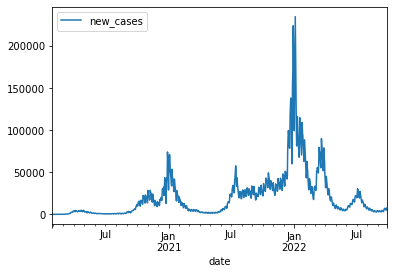

In [38]:
covid.plot()
plt.show()

---

### 🚩 Exercise 8

Plot the covid cases that happened in 2021

In [39]:
%run ../scripts/show_solutions.py 12_ex8

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

## Resampling

Now the covid data is nice and regular giving us one value per day. However what do we do when the data doesn't look like that? Lets have a look at another dataset, UFO sightings!

In [40]:
import pandas as pd

ufo = pd.read_csv('./Data/ufo.csv')

ufo.head()

,City,Colors Reported,Shape Reported,State,Time
0,Ithaca,NaN,TRIANGLE,NY,6/1/1930 22:00
1,Willingboro,NaN,OTHER,NJ,6/30/1930 20:00
2,Holyoke,NaN,OVAL,CO,2/15/1931 14:00
3,Abilene,NaN,DISK,KS,6/1/1931 13:00
4,New York Worlds Fair,NaN,LIGHT,NY,4/18/1933 19:00


Lets do some data cleaning to get this data ready to be used as a timeseries.

In [41]:
from helper_functions import clean_ufos

ufo = clean_ufos(ufo)

ufo.head()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01 22:00:00,Ithaca,NaN,TRIANGLE,NY
1930-06-30 20:00:00,Willingboro,NaN,OTHER,NJ
1931-02-15 14:00:00,Holyoke,NaN,OVAL,CO
1931-06-01 13:00:00,Abilene,NaN,DISK,KS
1933-04-18 19:00:00,New York Worlds Fair,NaN,LIGHT,NY


---

### 🚩 Exercise 9

Write your own function to clean the data as above (change `Time` to a `datetime` and set as an index)

In [42]:
%run ../scripts/show_solutions.py 12_ex9

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

Lets stop a second and think about out the UFO dataset. Is it a time series? 

It's a little ambiguous, but normally when we talk about time series data, we mean that recordings are made <em>at regular time intervals</em>. So we have a single (usually numeric) value for each day (or each month, or each second, or...)

Sometimes you do get time series with irregular intervals (like the ufo dataset), but we often then manipulate it into regular intervals.

So the ufo dataset isn't what we'd normally call a time series, because it has irregular intervals, and can have multiple records at the same time. We can convert it to a more regular time series by <em>resampling</em>. To do this, we need the time as the index of the dataframe, which is usual for time series.

Resampling to get one value every month: like `groupby`, `resample` needs an aggregate function to know how to combine multiple values in the same time period.

In [43]:
ufo.resample('M').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-30,2,0,2,2
1930-07-31,0,0,0,0
1930-08-31,0,0,0,0
1930-09-30,0,0,0,0
1930-10-31,0,0,0,0
...,...,...,...,...
2014-05-31,593,197,535,593
2014-06-30,709,216,669,710
2014-07-31,1006,386,929,1006


In [44]:
# can resample to year
ufo.resample('Y').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-12-31,2,0,2,2
1931-12-31,2,0,2,2
1932-12-31,0,0,0,0
1933-12-31,1,0,1,1
1934-12-31,1,0,1,1
...,...,...,...,...
2010-12-31,4154,849,3769,4154
2011-12-31,5087,1278,4650,5089
2012-12-31,7263,2239,6679,7263


In [45]:
# or day
ufo.resample('D').count()

,City,Colors Reported,Shape Reported,State
Time,,,,
1930-06-01,1,0,1,1
1930-06-02,0,0,0,0
1930-06-03,0,0,0,0
1930-06-04,0,0,0,0
1930-06-05,0,0,0,0
...,...,...,...,...
2014-09-01,25,7,22,25
2014-09-02,15,3,13,15
2014-09-03,24,8,23,24


Resampling can also be used to change the level of granularity. E.g., if you have hourly data and you want to study long term trends over a year, you might resample to daily, weekly, or monthly level with a sum or mean as aggregate

In [46]:
# make this resampling permanent, and also extract only the state column, 
# as that has no nulls in
ufo_state_count = ufo.resample('Y').count()['State']
ufo_state_count

Time
1930-12-31       2
1931-12-31       2
1932-12-31       0
1933-12-31       1
1934-12-31       1
              ... 
2010-12-31    4154
2011-12-31    5089
2012-12-31    7263
2013-12-31    7003
2014-12-31    5382
Freq: A-DEC, Name: State, Length: 85, dtype: int64

If we plot the data we can see that the number of sightings has been increasing, peaking in 2012.

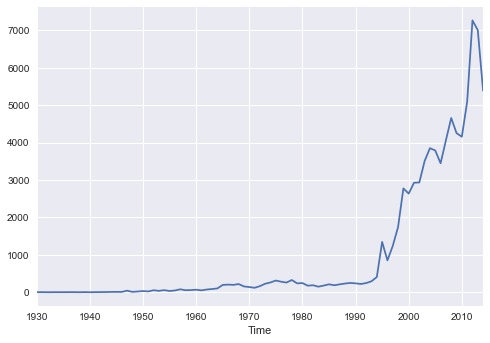

In [47]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

ufo_state_count.plot();

---

### 🚩 Exercise 10

Using the UK daily covid rate data resample to weekly counts level and plot a graph

In [48]:
%run ../scripts/show_solutions.py 12_ex10

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

## Trends